# Autocorrelation: Exploring Rossmann Drug Store Sales Data

This lab sets the foundation for ARIMA modeling. We will get to know our dataset, cover basic theory, and explore Python methods for managing time series data.

## Objectives:

- Explore Rossmann data
- Introduce technical concepts related to time series and ARIMA modeling 
- Calculate moving averages
- Analyze Autocorrelations

## Context:

> Key Definition: Time series data is any data that is captured across time.

We have captured daily sales data for [Rossmann](https://en.wikipedia.org/wiki/Rossmann_(company)) (German mart/pharmacy, like CVS). If we can use past sales data to predict future sales, we have autocorrelation among the feature "Sales". This is a solid foundation for modeling and we can determine how far back our model should look. The past two days might be insightful, but if we're predicting Monday sales, so might the previous two Mondays, etc.

However, if we go back too far, we complicate our model, and as expected, long ago data will not be very correlated with current sales.

Time series data usually contains more than meets the eye, and can often be decomposed into trend, seasonal, and random fluctuation components.

![Decomposition](http://rstatistics.net/wp-content/uploads/2014/09/Multiplicative-Decomposition-of-Time-series.png)

- Trends
    - Up
    - Down
    - Flat
    - Larger trends can be made up of smaller trends
    - There is no defined timeframe for what constitutes a trend; it depends on your goals
- Seasonal Effects
    - Weekend retail sales spikes
    - Holiday shopping
    - Energy requirement changes with annual weather patterns
    - Note: twitter spikes when news happens are not seasonal; they aren't regular and predictable
- Random Fluctuations
    - The human element
    - Aggregations of small influencers
    - Observation errors
    - The smaller this is in relation to Trend and Seasonal, the better we can predict the future
    
Time series models fall into [two camps](http://www.abs.gov.au/websitedbs/D3310114.nsf/home/Time+Series+Analysis:+The+Basics#HOW%20DO%20I%20KNOW%20WHICH%20DECOMPOSITION):
- Additive
    - Data = Trend + Seasonal + Random
    - What we will be using for our modeling
- Multiplicative
    - Data = Trend x Seasonal x Random
    - As easy to fit as Additive if we take the log
    - log(Data) = log(Trend x Seasonal x Random)

We should use **multiplicative models** when the **percentage change of our data is more important** than the absolute value change (e.g. stocks, commodities); as the trend rises and our values grow, we see amplitude growth in seasonal and random fluctuations.

## Time Series Modeling Process
Time series model selection is driven by the **Trend and Seasonal components** of our raw data. The general approach for analysis looks like this:

1. Plot the data and determine Trends and Seasonality
    1. Difference the data (multiple times if needed) to remove trends for [certain model applications](https://en.wikipedia.org/wiki/Stationary_process)
    1. Stationairity is needed for ARMA models
1. Determine if we have additive or multiplicative data patterns
1. Select the appropriate algorithm based on the chart below
1. Determine if model selection is correct with these tools
    - Ljung-Box Test
    - Residual Errors (Normal Distribution with zero mean and constant variance-homoskedastic)
    - Autocorrelation Function (ACF)
    - Partial Autocorrelation Function (PACF)

Algorithm | Trend | Seasonal | Correlations
---|---|---|---
ARIMA | X |X|X
SMA Smoothing |X||
Simple Exponential Smoothing |X||
Seasonal Adjustment |X|X|
Holt's Exponential Smoothing |X||
Holt-Winters |X|X|




In [4]:
# import packages and data
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Rossman data: Sales data of certain stores
data = pd.read_csv('https://s3.amazonaws.com/gamma-datasets/P2/rossmann.csv', skipinitialspace=True, low_memory=False)

In [5]:
# we are most interested in `Date` column that contains date of sales per store; convert to `DateTime` and set as index
# pull year and month as features
data['Date'] = pd.to_datetime(data['Date']) # Converting data into a timeseries to be understood
data.set_index('Date', inplace=True)

data['Year'] = data.index.year  # Extracting year and month for further analysis
data['Month'] = data.index.month

In [6]:
# sort dates to ascending and view

data.sort_index(inplace=True)
data.head()

# notice Monday is DayOfWeek 1

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,a,1,2013,1
2013-01-01,379,2,0,0,0,0,a,1,2013,1
2013-01-01,378,2,0,0,0,0,a,1,2013,1
2013-01-01,377,2,0,0,0,0,a,1,2013,1
2013-01-01,376,2,0,0,0,0,a,1,2013,1


In [9]:
# Check data for missing days

# first find the number of unique indices
len(data.index.unique())

942

In [10]:
# then calculate the delta in time plus one (inclusive of first day)
data.index.max() - data.index.min()

# counting the first day, we have a match: no missing dates!

Timedelta('941 days 00:00:00')

In [15]:
# describe and EDA
data.describe().round(2)   #.round(2) rounds the values to the second decimal place

# We are just looking at a glance to see if there are any anomalities/outliers
# - eg if your mean/max is really off
# - your quartile is very off

# eg: if you have a column like "age" and your max value is 1000.

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month
count,1017209.00,1017209.0,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00
mean,558.43,4.0,5773.82,633.15,0.83,0.38,0.18,2013.83,5.85
std,321.91,2.0,3849.93,464.41,0.38,0.49,0.38,0.78,3.33
min,1.00,1.0,0.00,0.00,0.00,0.00,0.00,2013.00,1.00
25%,280.00,2.0,3727.00,405.00,1.00,0.00,0.00,2013.00,3.00
50%,558.00,4.0,5744.00,609.00,1.00,0.00,0.00,2014.00,6.00
75%,838.00,6.0,7856.00,837.00,1.00,1.00,0.00,2014.00,8.00
max,1115.00,7.0,41551.00,7388.00,1.00,1.00,1.00,2015.00,12.00


In [13]:
# subset data to open dates
df = data[data.Open==1]  

# We should only look at subsets of data where the stores are open 
# (if the stores are closed, there are obviously no sales)

In [17]:
# pivot table of average sales with rows=month and cols as promotion or not
# Promo is only 0 or 1
pt = df.pivot_table(index='Month', columns='Promo', values='Sales')
pt


# We can see that the sales during the month of December + Promo is the highest!
# Can imply that holiday season and people are buying
# We are trying to figure out any pattern if the sales follows

Promo,0,1
Month,,
1,5591.904236,7782.800277
2,5747.812834,7772.909263
3,5805.723545,8252.983345
4,5855.305439,8426.029528
5,6300.749699,8087.946860
6,5871.747172,8508.684577
7,5751.911514,8257.588809
8,5680.220869,7926.496229
9,5528.634084,7916.399032


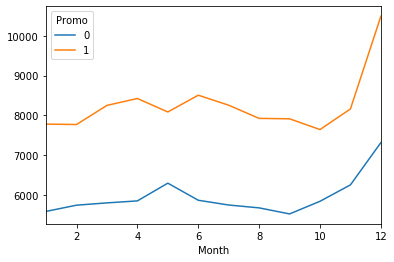

In [19]:
# We don't have to only just do this in a table. It might be easier to just visualize the data!

# plot average sales by month and promo
pt.plot();

# We can see that around the month 10-12 we can see a spike in sales!

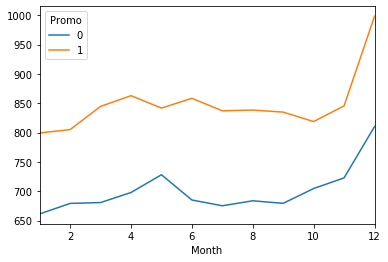

In [23]:
# IF my sales are spiking up, I can also look at customers
# Are my customers spiking up or are the sales just because same customers are buying more?

# plot average customers by month and promo
df.pivot_table(index='Month', columns='Promo', values='Customers').plot();

# And from here, we can see that the sales are increasing because we have an increasing customer base
# THis is what we observe graphically
# And we can see that our data is always some sort of time

In [25]:
# df of store 1 open day sales
store1 = df[df.Store == 1]

# Taking only just store number 1

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days. On state holidays the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

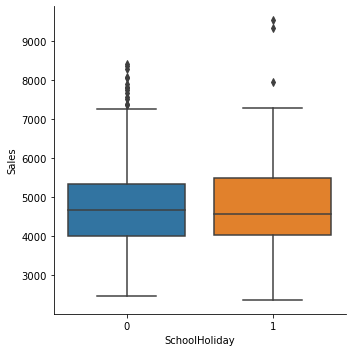

In [26]:
# do school holidays affect sales?
sns.catplot(
    x='SchoolHoliday',
    y='Sales',
    data=store1,
    kind='box');

In [30]:
store1.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
Date,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,2013,1
2013-01-03,1,4,4327,578,1,0,0,1,2013,1
2013-01-04,1,5,4486,619,1,0,0,1,2013,1
2013-01-05,1,6,4997,635,1,0,0,1,2013,1
2013-01-07,1,1,7176,785,1,1,0,1,2013,1


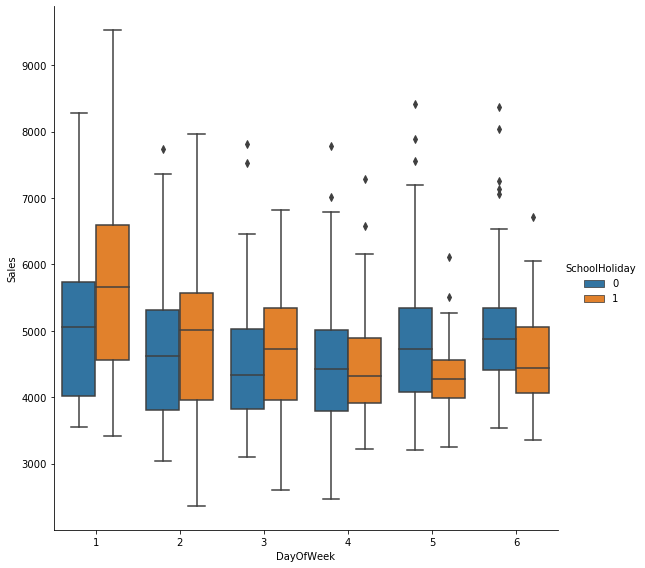

In [32]:
# does day of week affect sales?
sns.catplot(
    hue='SchoolHoliday',
    x='DayOfWeek',
    y='Sales',
    data=store1,
    kind='box',
    height=8);

# notice closed on Sundays. Therefore no 7

# We can also observe the same thing across days of the week!

# We can see that nearing the weekends, the sales data drops during the school holidays. What can we infer?
# Maybe people are not visitng the store. They are going somewhere else to spend their holidays instead of buying from the store

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

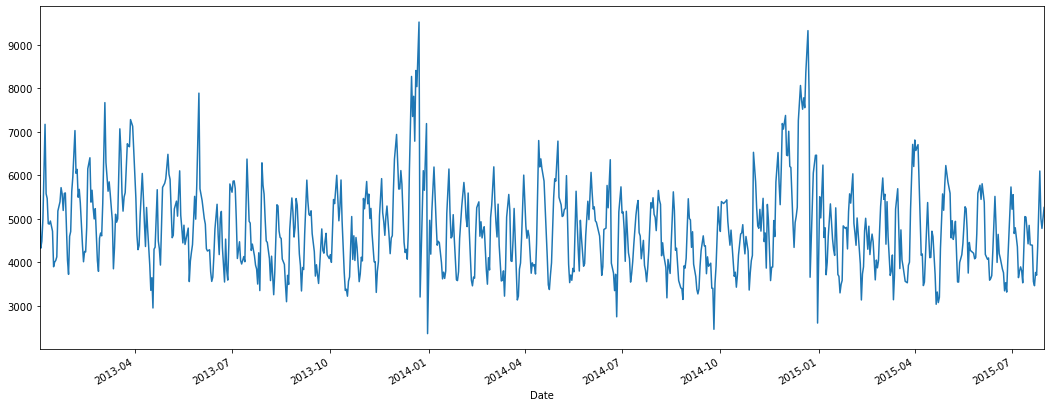

In [36]:
# plot store 1 sales when open
store1.Sales.plot(figsize=(18,7));

# Plotting sales of store1 completely across all the dates
# We can see that the spikes are consistent- that every year, during the end of the year there is some spike of sales
# So we can take this into account. For every 12 months, we can prepare for this spike.

# Actionable Steps:
# Eg. for a store, they will have more inventory put up during that period of the month.

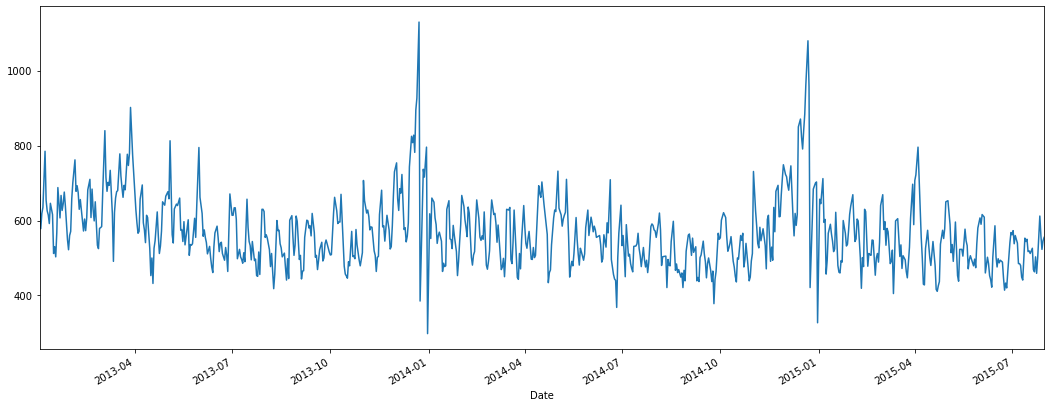

In [38]:
# plot store 1 customer count when open
store1.Customers.plot(figsize=(18,7));

# Checking your customer base

## Autocorrelation

In [ ]:
# Correlation is nothing but some inherent relationship between two data points

In [ ]:
# But in time data - there is no correlation with any other column. It is correlated on itself.
# Auto just implies it is correlated on itself

In [ ]:
# However things have happened in the past, they will affect how they happen in the future
# Therefore it is very important to understand correlation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we do this we with the `autocorr` function.

`autocorr` takes one argument, the `lag` - which is how many prior data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it, while setting `lag` to 10, computes the correlation between every point and the point 10 days earlier.

In [39]:
# resample all store data to average daily sales
daily_average_sales = df.Sales.resample('D').mean()  

daily_average_sales.head(10)

Date
2013-01-01    5719.705882
2013-01-02    6255.471647
2013-01-03    5723.913436
2013-01-04    5991.835740
2013-01-05    5376.326107
2013-01-06    7573.894737
2013-01-07    9789.193490
2013-01-08    7918.042534
2013-01-09    7010.500452
2013-01-10    7014.918552
Freq: D, Name: Sales, dtype: float64

In [40]:
# Check for a fortnightly autocorrelation

# check autocorrelation for previous two weeks
for i in range(1,16):
    print(i, daily_average_sales.autocorr(lag=i))   
    
    # Apply autocorr function with lag
    # lag = i means you test for all the lags to the latest value
    
# This shows you which lag is the most autocorrelated
# This shows that the 14 value has the most impact on your sales

1 0.42877053784467895
2 0.26007977818051004
3 0.18354704899834265
4 0.0650732802345305
5 -0.11382170682340323
6 -0.1493960851639721
7 0.15162539085841423
8 -0.17149625524368217
9 -0.16636050113018244
10 -0.04818259170595562
11 0.021786258586590803
12 0.07431024265340141
13 0.1814943558829656
14 0.580928689687614
15 0.17748408323767556


In [42]:
# check how many days after counts as a year, since some days are closed
len(data.index.unique()) - len(daily_average_sales.index.unique())

# across all stores, some are always open

0

In [43]:
# Check if there is a yearly pattern
# check yearly autocorr

for i in range(360,371):
    print(i, daily_average_sales.autocorr(lag=i))

# note the spike around 364-365

360 -0.016950392286052284
361 0.08672368567587814
362 0.11028292025906074
363 0.22917720283791845
364 0.6574960071246336
365 0.25701339164210496
366 0.139001069702897
367 0.11372966593810394
368 0.07115007644140933
369 -0.06545370570629247
370 -0.04366673901728026


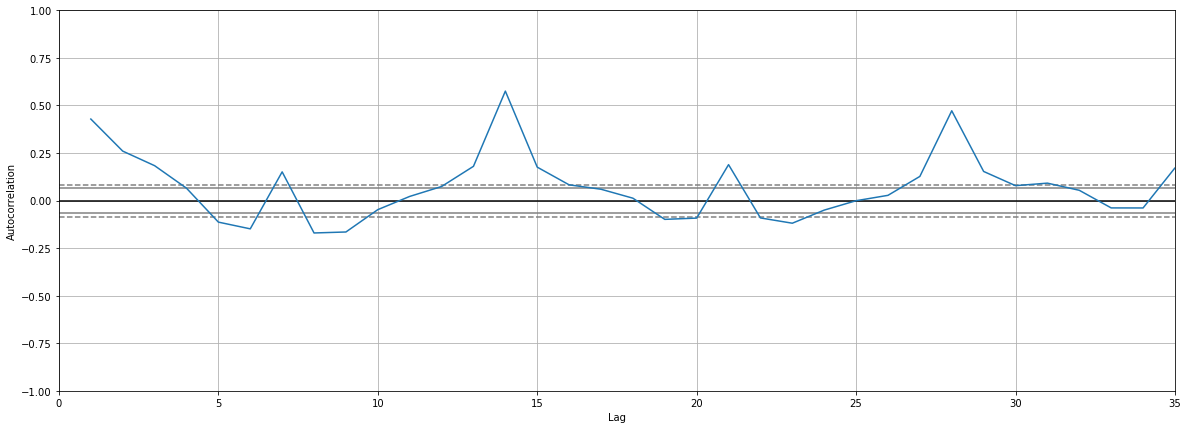

In [44]:
# plot autocorrelation for different lags using pandas
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(20,7))

autocorrelation_plot(daily_average_sales)
plt.xlim(0,35);

# Approaches to Modelling Time Series

## Moving/Rolling Averages (eg. my next day sales is going to be an average of the next window)

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  We want to know what the mean and median sales were for each month and year.

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - What aggregation to perform: 'mean', 'median', 'sum', etc.

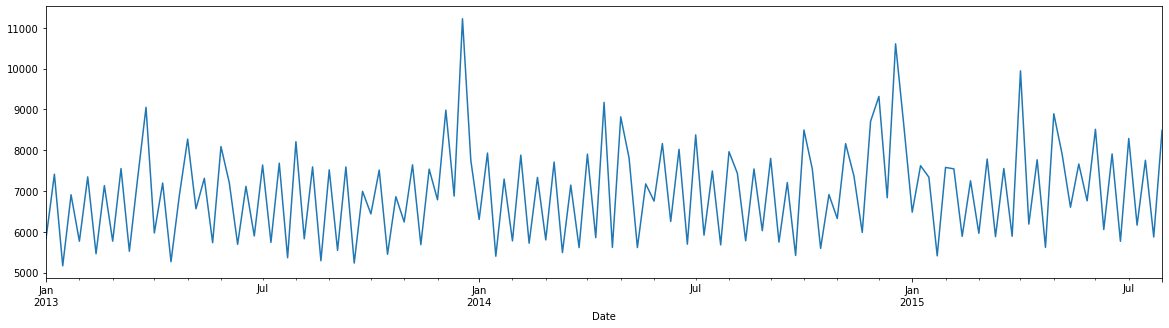

In [46]:
# resample original sales data total by week
weekly_average_sales = df.Sales.resample('W').mean()

weekly_average_sales.plot(figsize=(20,5));

While identifying the weekly averages are useful, we often want to compare the sales data of a **date to a smaller window**. To understand holidays sales, we don't want to compare late December with the entire month, but perhaps a few days surrounding it. We can do this using rolling averages.

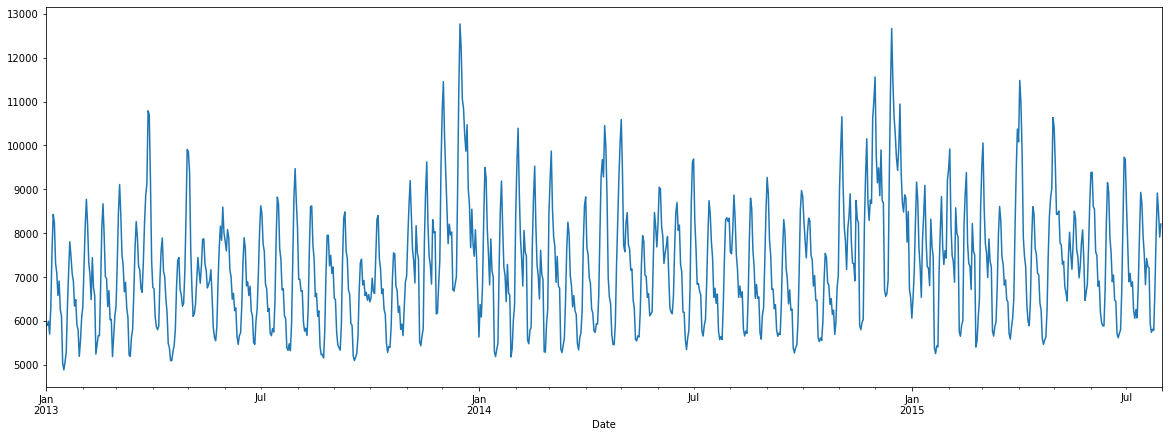

In [51]:
# find rolling daily mean

# Doing custom rolling windows
# Taking an average across every 3 days

daily_average_sales.rolling(window=3, center=True).mean().plot(figsize=(20,7));

# Because it is taking 3 days, which one of my data am i supposed to show? 
# So therefore, center just means you'll take your data at the center

# this gives us a bit of smoothing to exclude extreme events

`rolling` has these important parameters:
- the first is the series to aggregate
- `window` is the number of days to include in the average
- `center` is whether the window should be centered on the date or use data prior to that date
- `freq` level to roll-up averages to (as in `resample`). `D` for day, `M` for month or `A` for year, etc.

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

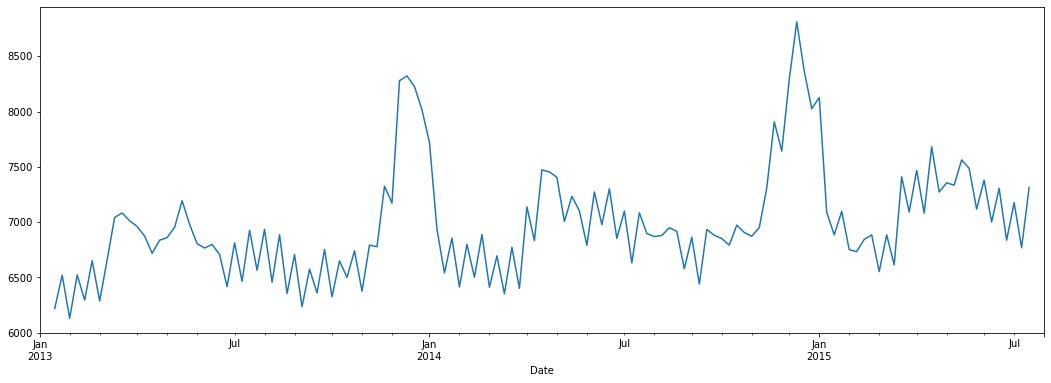

In [52]:
# plot 5-week centered rolling mean

weekly_average_sales.rolling(window=5, center=True).mean().plot(figsize=(18,6));

# Rollup every 5 weeks

## Pandas Window functions
Pandas `rolling` is an example of Pandas window function capabilities. Window functions operate on a set of N consecutive rows (a window) and produce an output: mean, median, min, max, sum, etc.

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one arugment, `periods`, which is how many prior rows to use for the difference. This is *extremely* useful for getting our data stationary!

In addition to `rolling` functions, Pandas provides a similar collection of `expanding` functions, which instead of a window, use all values up until that time.

C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


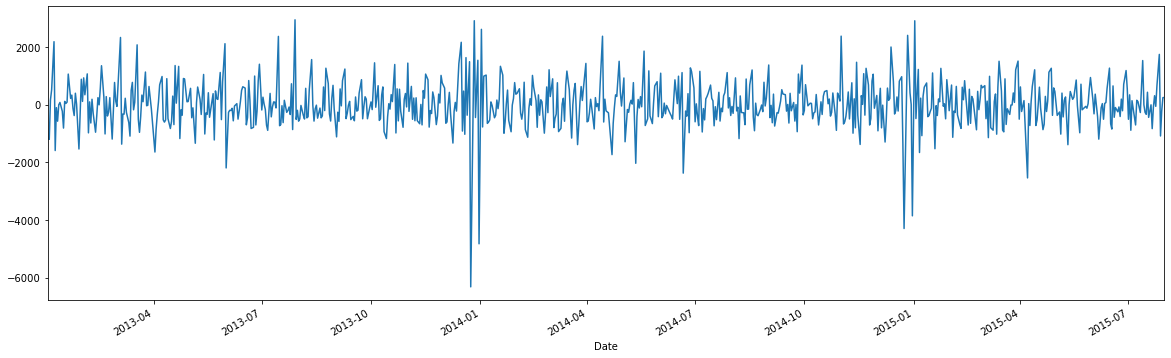

In [53]:
# calculate diff for open store 1 data

store1['Diff'] = store1['Sales'].diff(periods=1) # modelling by the difference in sales with the previous day
store1.Diff.plot(figsize=(20,6));

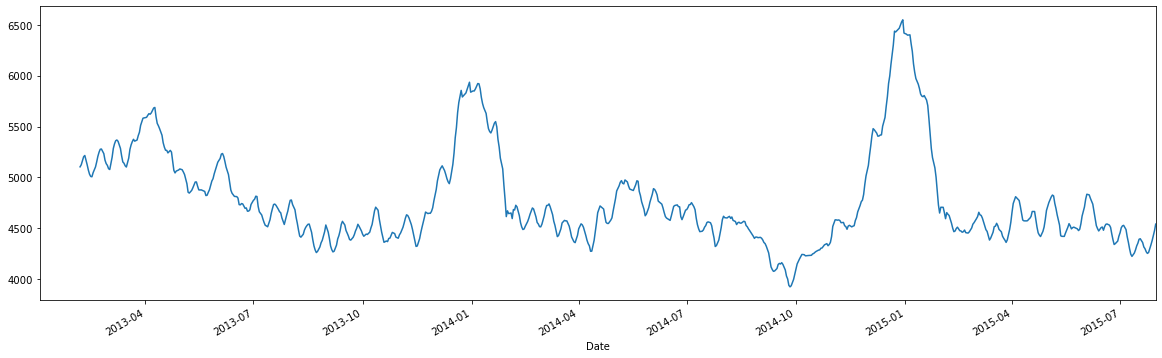

In [54]:
# plot 30-day rolling mean
store1.Sales.rolling(30).mean().plot(figsize=(20,6));
# notice the smoothing

In [55]:
# Expanding

In [56]:
# compute average daily expanding sales
daily_average_sales.expanding(min_periods=1).mean().head()

Date
2013-01-01    5719.705882
2013-01-02    5987.588765
2013-01-03    5899.696988
2013-01-04    5922.731676
2013-01-05    5813.450562
Freq: D, Name: Sales, dtype: float64

In [57]:
# does expanding sales at the last row work as assumed?
print(daily_average_sales.expanding(min_periods=1).mean().iloc[-1])
print
print(daily_average_sales.mean())

# yes, minus rounding errors!

7253.918504337242
7253.918504337253


# Exercises

In [ ]:
# plot the distribution of sales by month and compare the effect of promotions


In [ ]:
# Are sales more correlated with the prior day, day of week, last month, or last year?

# remake "daily_average_sales" but include Open data


In [ ]:
# plot the 15 day rolling mean of customers in the stores


In [ ]:
# identify the date with largest drop in average sales from previous cycles: daily, weekly, etc.


In [ ]:
# compute the total sales up until Dec. 2014


In [ ]:
# When were the largest differences between 15-day moving/rolling averages?


In [ ]:
# sort values

# Unsurprisingly, they occur at the beginning of every year after the holiday season

### How Differencing Works

Let's see how we can standardize our data (remove trends and changes in variance) via different levels of differencing. This is important, as standardized data is a requirement for ARIMA modeling.

In [58]:
# create a play dataframe from 1-10, regular and squared to test differencing works
play = pd.DataFrame([[x for x in range(1,11)], [x**2 for x in range(1,11)]]).T
play.columns = ['original', 'squared']
play

,original,squared
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25
5,6,36
6,7,49
7,8,64
8,9,81
9,10,100


In [59]:
# take diffs of our two series until they're stationary (mean doesn't change for sub-windows)
play.original.diff()

# This is a first order differencing
# this is similar to taking a first-order derivative

0    NaN
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: original, dtype: float64

In [62]:
play.squared.diff()

0     NaN
1     3.0
2     5.0
3     7.0
4     9.0
5    11.0
6    13.0
7    15.0
8    17.0
9    19.0
Name: squared, dtype: float64

In [61]:
play.squared.diff().diff() # This is a second order differencing

# notice we need to difference twice on an exponential trend, and every time we do, we lose a bit of data

0    NaN
1    NaN
2    2.0
3    2.0
4    2.0
5    2.0
6    2.0
7    2.0
8    2.0
9    2.0
Name: squared, dtype: float64

## Objectives:

- Explore Rossmann data
- Introduce technical concepts related to time series and ARIMA modeling 
- Calculate moving averages
- Analyze Autocorrelations